table of contents
1. データの読み込み
1. 前処理
1. 可視化

In [12]:
import os

import numpy as np
import pandas as pd

import dataframe_image as dfi

import plotly
import plotly.express as px

plotly.offline.init_notebook_mode(connected=False)

plotly.io.orca.config.executable = '/Users/yamamuros83/.pyenv/versions/anaconda3-5.3.1/envs/spoana/bin/orca'

In [2]:
base_dir = '..'

data_dir = os.path.join(base_dir, 'data')

repo_dir = os.path.join(base_dir, 'reports')

# データの読み込み

## 新卒マスタ

In [3]:
mst_df = pd.read_csv(os.path.join(data_dir, 'shinsotsu-player.csv'))

In [4]:
mst_df.head()

player_name from_team_name     年度 competition
0        茂木駿佑          仙台ユース  2015年       Ｊ１リーグ
1        西村拓真          富山第一高  2015年       Ｊ１リーグ
2        摂津颯登          山形ユース  2015年       Ｊ１リーグ
3        高木利弥           神奈川大  2015年       Ｊ１リーグ
4        大橋尚志          鹿島ユース  2015年       Ｊ１リーグ

## 出場時間データ

In [5]:
import re

def get_df(mst_df_tmp, data_dir_tmp, stage_flg=False):
    df_tmp_list = []
    infile_list = [infile for infile in os.listdir(data_dir_tmp) if infile.endswith('.csv')]
    for infile in infile_list:
        df = pd.read_csv(os.path.join(data_dir_tmp, infile), index_col=0)
        unpivoted_df = pd.melt(df[df.index.isin(mst_df_tmp.player_name.tolist())], ignore_index=False).reset_index()
        unpivoted_df.columns = ['player_name', '節', 'value']

        unpivoted_df['節'] = unpivoted_df[['節']].apply(lambda x: int(re.search(r'\d+', str(x).replace('.1','')).group()), axis=1)
        if stage_flg:
            unpivoted_df['節'] = unpivoted_df['節'] + 17
            
        unpivoted_df['to_team_name'] = infile.split('.')[0]
        df_tmp = pd.merge(unpivoted_df, mst_df_tmp, on='player_name', how='left')
        
        df_tmp_list.append(df_tmp)
    
    return pd.concat(df_tmp_list)

df_list = list()

for year in mst_df['年度'].unique():
    for competition in mst_df['competition'].unique():
        mst_df_tmp = mst_df[(mst_df['年度']==year)&(mst_df['competition']==competition)]
        if competition=='Ｊ１リーグ' and year in ['2015年', '2016年']:
            data_dir_ = os.path.join(data_dir, year, competition)
            for stage in os.listdir(data_dir_):
                data_dir_tmp = os.path.join(data_dir_, stage)
                df_list.append(get_df(mst_df_tmp, data_dir_tmp, stage=='２ｎｄ'))
        else:
            data_dir_tmp = os.path.join(data_dir, year, competition)
            df_list.append(get_df(mst_df_tmp, data_dir_tmp))

df = pd.concat(df_list)
# 松田陸を外す
df = df[~((df.player_name=='松田陸')&(df.to_team_name=='Ｃ大阪'))]

# 前処理

In [6]:
df['n_minute'] = df.value.apply(lambda x: 
                                np.nan if  str(x) in ['NaN', 'nan', '×', '抹消', '追加', '※']
                                else 0 if x=='SUB'
                                else 90 if str(x).startswith('○')
                                else int(str(x).replace('▲','').replace('◆','').replace('▽','').replace('①','').replace('②','').replace('③','').replace('C','').replace('S',''))
                                )

In [7]:
df.head()

player_name     節 value to_team_name from_team_name     年度 competition  \
0         松原后  18.0   SUB           清水         浜松開誠館高  2015年       Ｊ１リーグ   
1        水谷拓磨  18.0   ▲27           清水          清水ユース  2015年       Ｊ１リーグ   
2        北川航也  18.0   ▲12           清水          清水ユース  2015年       Ｊ１リーグ   
3         松原后  19.0    ▲8           清水         浜松開誠館高  2015年       Ｊ１リーグ   
4        水谷拓磨  19.0   NaN           清水          清水ユース  2015年       Ｊ１リーグ   

   n_minute  
0       0.0  
1      27.0  
2      12.0  
3       8.0  
4       NaN

# 可視化

## 新卒Jリーガーの出場時間（2015〜2019）

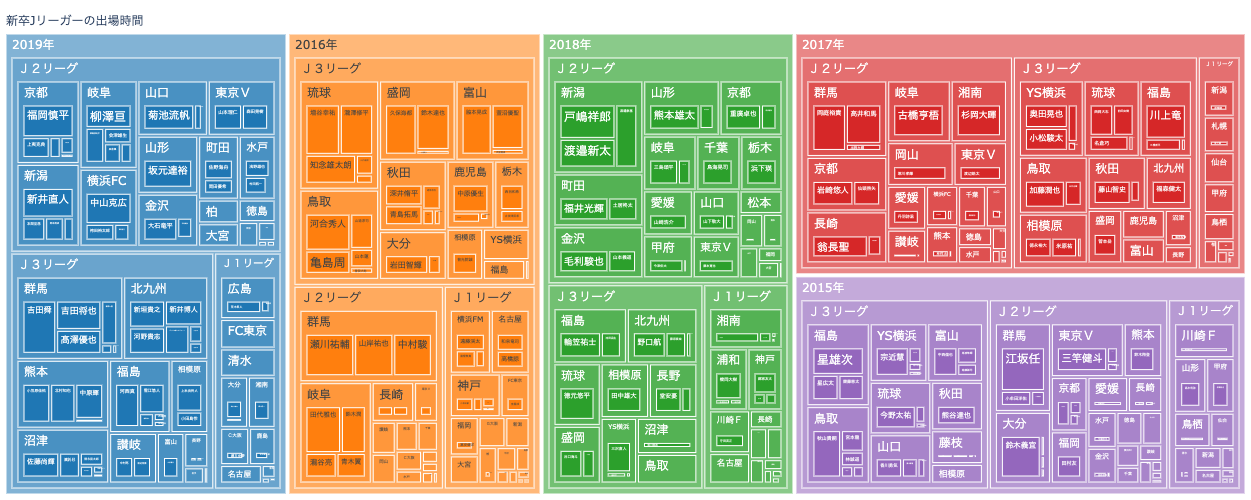

In [8]:
fig = px.treemap(df[(df.n_minute>0)&(df['年度']!='2020年')].dropna().sort_values('年度'), 
           path=[px.Constant('新卒Jリーガーの出場時間'), '年度', 'competition', 'to_team_name', 'player_name'], values='n_minute',
           color_discrete_sequence=px.colors.qualitative.D3,
           height=500, width=1000
)

fig.update_layout(margin=dict(t=10, r=0, b=0, l=0))

## 新卒Jリーガーの出場時間（2020）

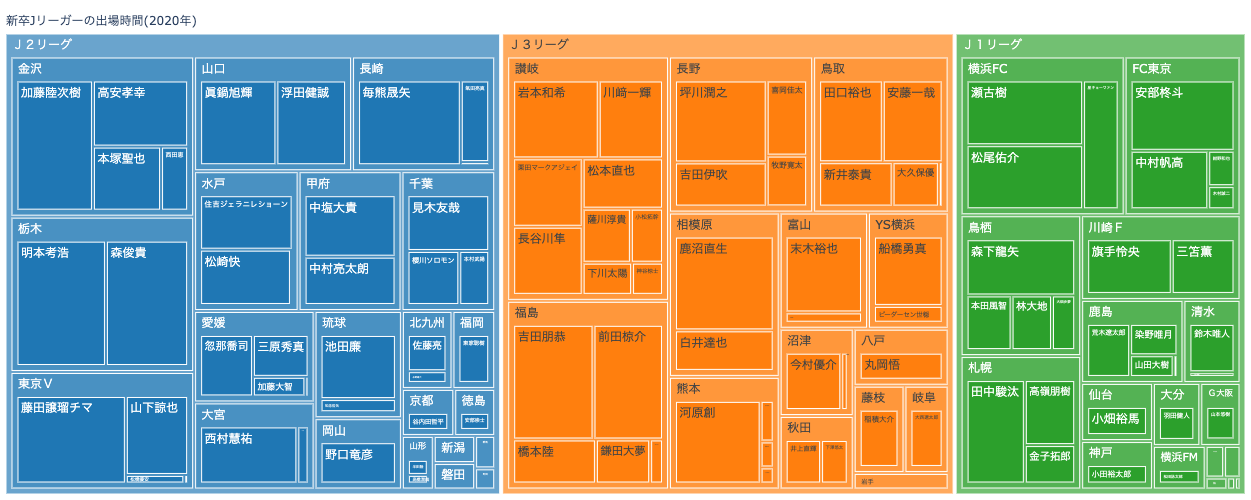

In [13]:
fig = px.treemap(df[(df.n_minute>0)&(df['年度']=='2020年')].dropna().sort_values('年度'), 
           path=[px.Constant('新卒Jリーガーの出場時間(2020年)'), 'competition', 'to_team_name', 'player_name'], values='n_minute',
           color_discrete_sequence=px.colors.qualitative.D3,
           height=500, width=1000
)

fig.update_layout(margin=dict(t=10, r=0, b=0, l=0))

fig.write_image(os.path.join(repo_dir, 'treemap-to_team_name_year=2020.png'))

fig

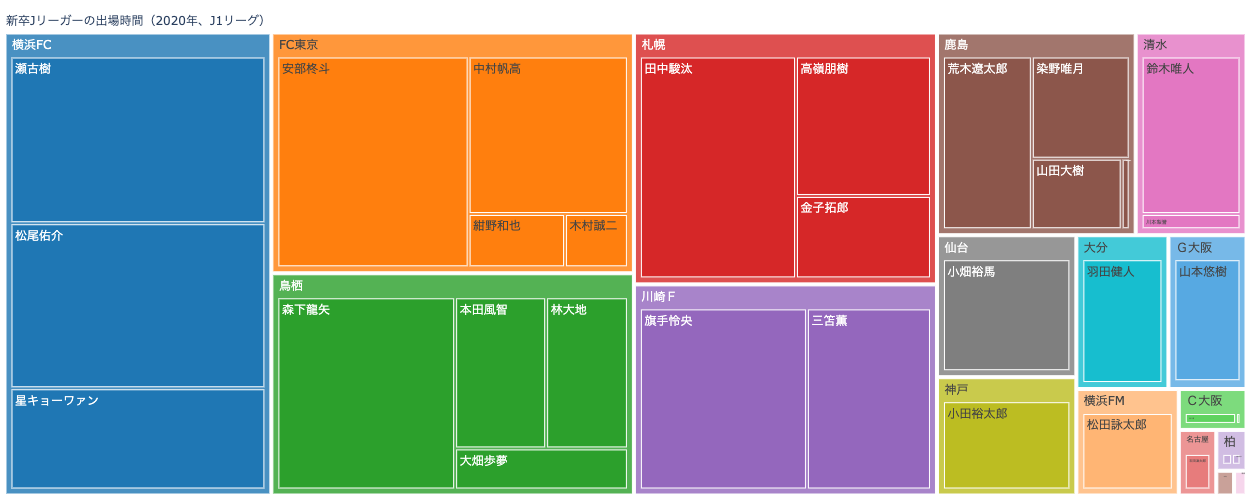

In [15]:
fig = px.treemap(df[(df.n_minute>0)&(df['年度']=='2020年')&(df['competition']=='Ｊ１リーグ')].dropna().sort_values('年度'), 
           path=[px.Constant('新卒Jリーガーの出場時間（2020年、J1リーグ）'), 'to_team_name', 'player_name'], values='n_minute',
           color_discrete_sequence=px.colors.qualitative.D3,
           height=500, width=1000
)

fig.update_layout(margin=dict(t=10, r=0, b=0, l=0))

fig.write_image(os.path.join(repo_dir, 'treemap-to_team_name_year=2020-competition=j1.png'))

fig

## 新卒Jリーガーの出場時間マップ

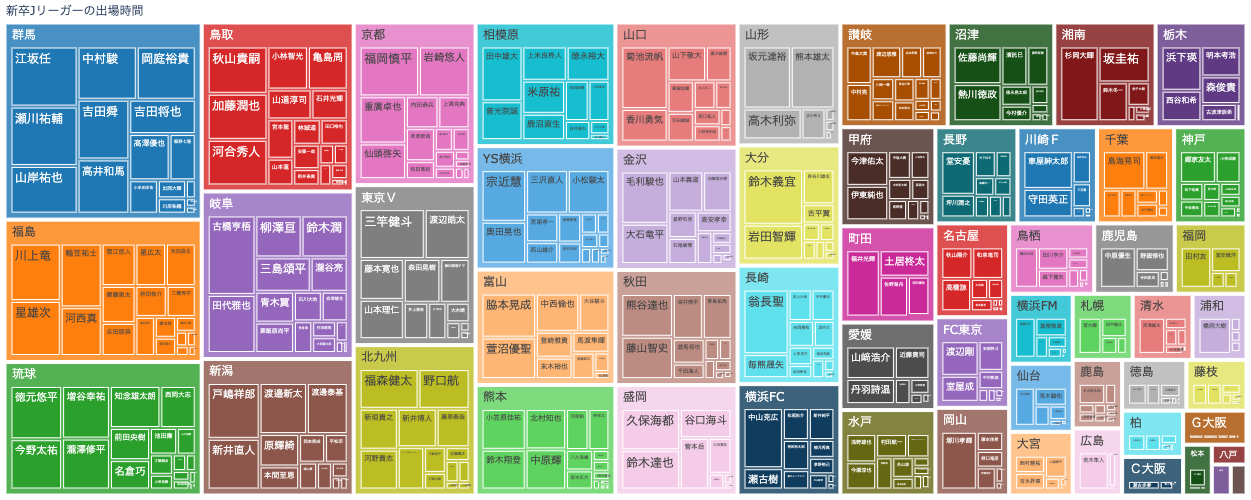

In [16]:
fig = px.treemap(df[(df.n_minute>0)].dropna().sort_values('年度'), 
           path=[px.Constant('新卒Jリーガーの出場時間'), 'to_team_name', 'player_name'], values='n_minute',
           color_discrete_sequence=px.colors.qualitative.D3,
           height=500, width=1200
)

fig.update_layout(margin=dict(t=0,r=0,b=0,l=0))

fig.write_image(os.path.join(repo_dir, 'treemap-to_team_name.png'))

fig

## 新卒Jリーガーの出場時間（J1）

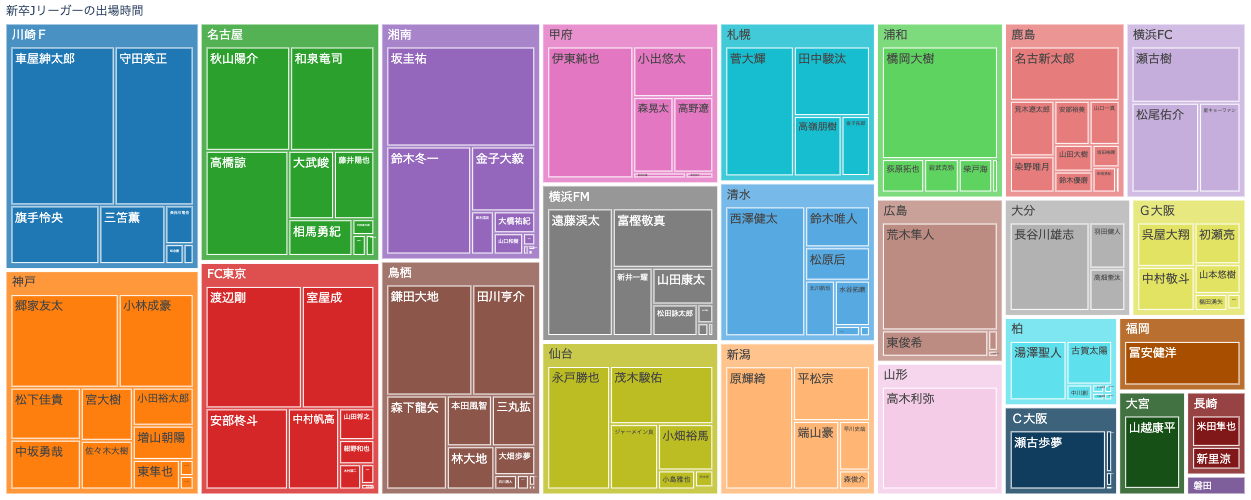

In [17]:
fig = px.treemap(df[(df['competition']=='Ｊ１リーグ')&(df.n_minute>0)].dropna().sort_values('年度'), 
           path=[px.Constant('新卒Jリーガーの出場時間'), 'to_team_name', 'player_name'], values='n_minute',
           color_discrete_sequence=px.colors.qualitative.D3,
           height=500, width=1200
)

fig.update_layout(margin=dict(t=0,r=0,b=0,l=0))

fig.write_image(os.path.join(repo_dir, 'treemap-to_team_name-j1.png'))

fig